In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import squidpy as sq
from skimage import io
from sklearn import preprocessing
from tqdm.notebook import tqdm, trange
import anndata as ad

In [2]:
p_dir = (Path().cwd().parents[0].parents[0]).absolute()
data_dir = p_dir / "09_datasets"

In [5]:
dataset_1 = data_dir / '01_codex_data'
dataset_2 = data_dir / '02_tissue_architecture'
dataset_3 = data_dir / '03_Sci_Data_Cycif' 
dataset_4 = data_dir / '04_codex_nature_pro' 
dataset_5 = data_dir / '05_MCMICRO' / 'TNP_pilot_cycif' 

masks_folder = data_dir / 'exported' / 'masks'

In [6]:
csv_path = dataset_4 / 'Tonsil_Clustering16_K46.csv'
df = pd.read_csv(csv_path)

In [14]:
print(list(df.columns))

['ClusterID', 'EventID', 'File Name', 'Index in File', 'Event Name', 'Comment', 'Cyc_2_ch_4 (CD56):Cyc_2_ch_4 (CD56)', 'Cyc_3_ch_3 (FoxP3):Cyc_3_ch_3 (FoxP3)', 'Cyc_3_ch_4 (CD21):Cyc_3_ch_4 (CD21)', 'Cyc_4_ch_2 (MUC1):Cyc_4_ch_2 (MUC1)', 'Cyc_4_ch_4 (PD1):Cyc_4_ch_4 (PD1)', 'Cyc_5_ch_2 (CD11b):Cyc_5_ch_2 (CD11b)', 'Cyc_5_ch_3 (CD4):Cyc_5_ch_3 (CD4)', 'Cyc_5_ch_4 (Ki67):Cyc_5_ch_4 (Ki67)', 'Cyc_6_ch_2 (CD31):Cyc_6_ch_2 (CD31)', 'Cyc_6_ch_3 (CD25):Cyc_6_ch_3 (CD25)', 'Cyc_7_ch_2 (CD15):Cyc_7_ch_2 (CD15)', 'Cyc_7_ch_3 (CD20):Cyc_7_ch_3 (CD20)', 'Cyc_7_ch_4 (Annexin A1):Cyc_7_ch_4 (Annexin A1)', 'Cyc_8_ch_2 (aSMA):Cyc_8_ch_2 (aSMA)', 'Cyc_8_ch_3 (CD11c):Cyc_8_ch_3 (CD11c)', 'Cyc_8_ch_4 (Nestin):Cyc_8_ch_4 (Nestin)', 'Cyc_9_ch_4 (IDO):Cyc_9_ch_4 (IDO)', 'Cyc_10_ch_2 (Cytokeratin):Cyc_10_ch_2 (Cytokeratin)', 'Cyc_11_ch_2 (Vimentin):Cyc_11_ch_2 (Vimentin)', 'Cyc_11_ch_4 (CD36):Cyc_11_ch_4 (CD36)', 'Cyc_12_ch_3 (HLADR):Cyc_12_ch_3 (HLADR)', 'Cyc_13_ch_3 (BCL2):Cyc_13_ch_3 (BCL2)', 'Cyc_14_ch_4

In [12]:
name = df.columns.tolist()
name = [n.split(' ')[-1].replace('(','').replace(')','') if 'Cyc_' in n else n for n in name]

In [25]:
protein_columns = ['Cyc_2_ch_4 (CD56):Cyc_2_ch_4 (CD56)', 'Cyc_3_ch_3 (FoxP3):Cyc_3_ch_3 (FoxP3)', 'Cyc_3_ch_4 (CD21):Cyc_3_ch_4 (CD21)', 'Cyc_4_ch_2 (MUC1):Cyc_4_ch_2 (MUC1)', 'Cyc_4_ch_4 (PD1):Cyc_4_ch_4 (PD1)', 'Cyc_5_ch_2 (CD11b):Cyc_5_ch_2 (CD11b)', 'Cyc_5_ch_3 (CD4):Cyc_5_ch_3 (CD4)', 'Cyc_5_ch_4 (Ki67):Cyc_5_ch_4 (Ki67)', 'Cyc_6_ch_2 (CD31):Cyc_6_ch_2 (CD31)', 'Cyc_6_ch_3 (CD25):Cyc_6_ch_3 (CD25)', 'Cyc_7_ch_2 (CD15):Cyc_7_ch_2 (CD15)', 'Cyc_7_ch_3 (CD20):Cyc_7_ch_3 (CD20)', 'Cyc_7_ch_4 (Annexin A1):Cyc_7_ch_4 (Annexin A1)', 'Cyc_8_ch_2 (aSMA):Cyc_8_ch_2 (aSMA)', 'Cyc_8_ch_3 (CD11c):Cyc_8_ch_3 (CD11c)', 'Cyc_8_ch_4 (Nestin):Cyc_8_ch_4 (Nestin)', 'Cyc_9_ch_4 (IDO):Cyc_9_ch_4 (IDO)', 'Cyc_10_ch_2 (Cytokeratin):Cyc_10_ch_2 (Cytokeratin)', 'Cyc_11_ch_2 (Vimentin):Cyc_11_ch_2 (Vimentin)', 'Cyc_11_ch_4 (CD36):Cyc_11_ch_4 (CD36)', 'Cyc_12_ch_3 (HLADR):Cyc_12_ch_3 (HLADR)', 'Cyc_13_ch_3 (BCL2):Cyc_13_ch_3 (BCL2)', 'Cyc_14_ch_4 (p63):Cyc_14_ch_4 (p63)', 'Cyc_15_ch_4 (CD3):Cyc_15_ch_4 (CD3)', 'Cyc_16_ch_3 (CD45):Cyc_16_ch_3 (CD45)', 'Cyc_16_ch_4 (CD8):Cyc_16_ch_4 (CD8)', 'Cyc_17_ch_3 (CD57):Cyc_17_ch_3 (CD57)', 'Cyc_18_ch_4 (CD68):Cyc_18_ch_4 (CD68)', 'Cyc_19_ch_3 (CD34):Cyc_19_ch_3 (CD34)', 'Cyc_20_ch_3 (CD38):Cyc_20_ch_3 (CD38)', 'Cyc_20_ch_4 (Podoplanin):Cyc_20_ch_4 (Podoplanin)', 'Cyc_21_ch_3 (CD163):Cyc_21_ch_3 (CD163)', 'Cyc_21_ch_4 (Bcatenin):Cyc_21_ch_4 (Bcatenin)', 'Cyc_22_ch_3 (CD138):Cyc_22_ch_3 (CD138)', 'Cyc_22_ch_4 (Arginase1):Cyc_22_ch_4 (Arginase1)', 'Cyc_23_ch_3 (CD73):Cyc_23_ch_3 (CD73)', 'Cyc_23_ch_4 (CD206):Cyc_23_ch_4 (CD206)', 'Cyc_24_ch_4 (COX2):Cyc_24_ch_4 (COX2)', 'Cyc_25_ch_3 (MMP9):Cyc_25_ch_3 (MMP9)', 'Cyc_2_ch_3 (PDL1):Cyc_2_ch_3 (PDL1)', 'Cyc_10_ch_3 (p53):Cyc_10_ch_3 (p53)']

protein_name = ['CD56', 'FoxP3', 'CD21', 'MUC1', 'PD1', 'CD11b', 'CD4', 'Ki67', 'CD31', 'CD25', 'CD15', 'CD20', 'A1', 'aSMA', 'CD11c', 'Nestin', 'IDO', 'Cytokeratin', 'Vimentin', 'CD36', 'HLADR', 'BCL2', 'p63', 'CD3', 'CD45', 'CD8', 'CD57', 'CD68', 'CD34', 'CD38', 'Podoplanin', 'CD163', 'Bcatenin', 'CD138', 'Arginase1', 'CD73', 'CD206', 'COX2', 'MMP9', 'PDL1', 'p53']

meta_columns = ['ClusterID', 'EventID', 'File Name', 'X (X):X (X)', 'Y (Y):Y (Y)']

meta = ['ClusterID', 'EventID', 'File Name', 'x_in_file', 'y_in_file']

In [26]:
x = df['X (X):X (X)'].to_numpy().astype(int)
y = df['Y (Y):Y (Y)'].to_numpy().astype(int)

spatial = np.vstack([y, x]).T

In [23]:
adata = ad.AnnData(df[protein_columns].values)
adata.var_names = protein_name
adata.obs = df[meta_columns]
adata.obs.columns = meta
adata.obsm['spatial'] = spatial

C:\Users\thu71\AppData\Local\Temp\ipykernel_43200\1349207622.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(df[protein_columns].values)


In [40]:
print(protein_name)

['CD56', 'FoxP3', 'CD21', 'MUC1', 'PD1', 'CD11b', 'CD4', 'Ki67', 'CD31', 'CD25', 'CD15', 'CD20', 'A1', 'aSMA', 'CD11c', 'Nestin', 'IDO', 'Cytokeratin', 'Vimentin', 'CD36', 'HLADR', 'BCL2', 'p63', 'CD3', 'CD45', 'CD8', 'CD57', 'CD68', 'CD34', 'CD38', 'Podoplanin', 'CD163', 'Bcatenin', 'CD138', 'Arginase1', 'CD73', 'CD206', 'COX2', 'MMP9', 'PDL1', 'p53']


In [43]:
group = df.groupby('File Name')


In [47]:
print(df.columns)

Index(['ClusterID', 'EventID', 'File Name', 'Index in File', 'Event Name',
       'Comment', 'Cyc_2_ch_4 (CD56):Cyc_2_ch_4 (CD56)',
       'Cyc_3_ch_3 (FoxP3):Cyc_3_ch_3 (FoxP3)',
       'Cyc_3_ch_4 (CD21):Cyc_3_ch_4 (CD21)',
       'Cyc_4_ch_2 (MUC1):Cyc_4_ch_2 (MUC1)',
       'Cyc_4_ch_4 (PD1):Cyc_4_ch_4 (PD1)',
       'Cyc_5_ch_2 (CD11b):Cyc_5_ch_2 (CD11b)',
       'Cyc_5_ch_3 (CD4):Cyc_5_ch_3 (CD4)',
       'Cyc_5_ch_4 (Ki67):Cyc_5_ch_4 (Ki67)',
       'Cyc_6_ch_2 (CD31):Cyc_6_ch_2 (CD31)',
       'Cyc_6_ch_3 (CD25):Cyc_6_ch_3 (CD25)',
       'Cyc_7_ch_2 (CD15):Cyc_7_ch_2 (CD15)',
       'Cyc_7_ch_3 (CD20):Cyc_7_ch_3 (CD20)',
       'Cyc_7_ch_4 (Annexin A1):Cyc_7_ch_4 (Annexin A1)',
       'Cyc_8_ch_2 (aSMA):Cyc_8_ch_2 (aSMA)',
       'Cyc_8_ch_3 (CD11c):Cyc_8_ch_3 (CD11c)',
       'Cyc_8_ch_4 (Nestin):Cyc_8_ch_4 (Nestin)',
       'Cyc_9_ch_4 (IDO):Cyc_9_ch_4 (IDO)',
       'Cyc_10_ch_2 (Cytokeratin):Cyc_10_ch_2 (Cytokeratin)',
       'Cyc_11_ch_2 (Vimentin):Cyc_11_ch_2 (Vimentin)'

In [49]:
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 256
color_array = plt.get_cmap('autumn_r')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)**2
map_reds = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

# get colormap
ncolors = 256
color_array = plt.get_cmap('winter')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)**2
map_greens = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

# get colormap
ncolors = 256
color_array = plt.get_cmap('winter_r')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)**2
map_blues = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)


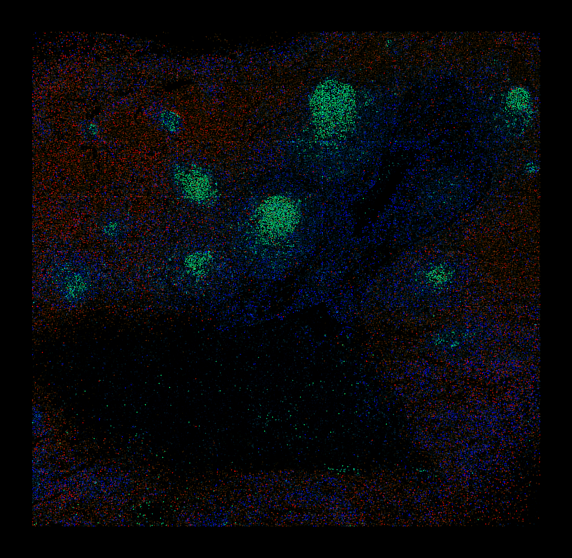

In [52]:
le = preprocessing.MinMaxScaler()

x = df['X (X):X (X)'].to_numpy().astype(int)
y = df['Y (Y):Y (Y)'].to_numpy().astype(int)

max_x = np.max(x)
max_y = np.min(y)
img = np.zeros((max_y, max_x), dtype=np.uint8)

c = df['Cyc_7_ch_3 (CD20):Cyc_7_ch_3 (CD20)'].to_numpy()
c1 = le.fit_transform(c.reshape(-1, 1))
c = df['Cyc_3_ch_4 (CD21):Cyc_3_ch_4 (CD21)'].to_numpy()
c2 = le.fit_transform(c.reshape(-1, 1))
c = df['Cyc_15_ch_4 (CD3):Cyc_15_ch_4 (CD3)'].to_numpy()
c3 = le.fit_transform(c.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(10,10), facecolor='k')
ax.scatter(x, y, c=c1, s=0.1, cmap=map_blues, vmin=np.quantile(c1, 0.02), vmax=np.quantile(c1, 0.98))
ax.scatter(x, y, c=c2, s=0.1, cmap=map_greens, vmin=np.quantile(c2, 0.02), vmax=np.quantile(c2, 0.99))
ax.scatter(x, y, c=c3, s=0.1, cmap=map_reds, vmin=np.quantile(c3, 0.02), vmax=np.quantile(c3, 0.995))
ax.axis('off')
plt.show()